In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

def superjackknife(dats_jk):
    Nens=len(dats_jk)
    Ncfgss=[len(dat) for dat in dats_jk]
    dats_jkmean=[np.mean(dat_jk,axis=0) for dat_jk in dats_jk]
    t=[[dats_jk[i] if i==j else np.repeat(dats_jkmean[j][None,:],Ncfgss[i],axis=0) for j in range(Nens)] for i in range(Nens)]
    return np.block(t)

from scipy.optimize import leastsq, curve_fit, fsolve
from scipy.linalg import solve_triangular,cholesky
def jackfit(fitfunc,y_jk,pars0,mask=None,cov=None):
    y_mean,_,y_cov=yu.jackmec(y_jk)
    if cov is not None:
        y_cov=cov
    if mask is not None:
        if mask == 'uncorrelated':
            y_cov=np.diag(np.diag(y_cov))
        else:
            y_cov=y_cov*mask
        
    cho_L_Inv = np.linalg.inv(cholesky(y_cov, lower=True)) # y_cov^{-1}=cho_L_Inv^T@cho_L_Inv
    fitfunc_wrapper=lambda pars: cho_L_Inv@(fitfunc(pars)-y_mean)
    
    pars_mean,pars_cov=leastsq(fitfunc_wrapper,pars0,full_output=True)[:2]
    
    def func(dat):
        fitfunc_wrapper2=lambda pars: cho_L_Inv@(fitfunc(pars)-dat)
        pars=leastsq(fitfunc_wrapper2,pars_mean)[0]
        return pars
    pars_jk=yu.jackmap(func,y_jk)

    chi2_jk=np.array([[np.sum(fitfunc_wrapper(pars)**2)] for pars in pars_jk])
    Ndata=len(y_mean); Npar=len(pars0); Ndof=Ndata-Npar
    return pars_jk,chi2_jk,Ndof

enss=['b','c','d']

ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

def getQ2(ens,n2):
    mN=0.938
    q2=(2*np.pi/(ens2N[ens])*ens2aInv[ens]/1000)**2 * n2
    EN=np.sqrt(mN**2+q2)
    Q2=q2 - (EN-mN)**2
    return Q2

In [5]:
import h5py
import numpy as np

def superjackknife(dats_jk):
    Nens=len(dats_jk)
    Ncfgss=[len(dat) for dat in dats_jk]
    dats_jkmean=[np.mean(dat_jk,axis=0) for dat_jk in dats_jk]
    t=[[dats_jk[i] if i==j else np.repeat(dats_jkmean[j][None,:],Ncfgss[i],axis=0) for j in range(Nens)] for i in range(Nens)]
    return np.block(t)

path='/capstor/store/cscs/userlab/s1174/lyan/code/temp/input.h5'
path2='/capstor/store/cscs/userlab/s1174/lyan/code/temp/output.h5'
with h5py.File(path) as f, h5py.File(path2) as fo:
    for ky1 in f.keys():
        for ky2 in f[ky1].keys():
            dats_jk=[f[f'{ky1}/{ky2}/{ens}'][:] for ens in ['cB64','cC80','cD96']]

            sj=superjackknife(dats_jk)
            sj_out=fo[f'{ky1}/{ky2}'][:]
            
            # ratio=sj_out/sj
            # print(ratio[0])
            print(np.max(np.abs(sj)),np.max(np.abs(sj-sj_out)))
            # break
        # break

0.4449833155300907 6.106226635438361e-16
0.19175227219418442 1.942890293094024e-16
0.057905843932894045 3.469446951953614e-17
0.19804209395872935 1.942890293094024e-16


expected 1 0.0049326362366699005
jack (1.0020944461612005, 0.005013563718805184)
super 1.0019399967588172 0.0050133011773603265
chi2 1.0524375510743373 0.000461051143692406
for 1st
expected 1 0.03779644730092272
jack 0.998438682776938 0.035954649547185344
super 0.9984386827769123 0.03596911336924374


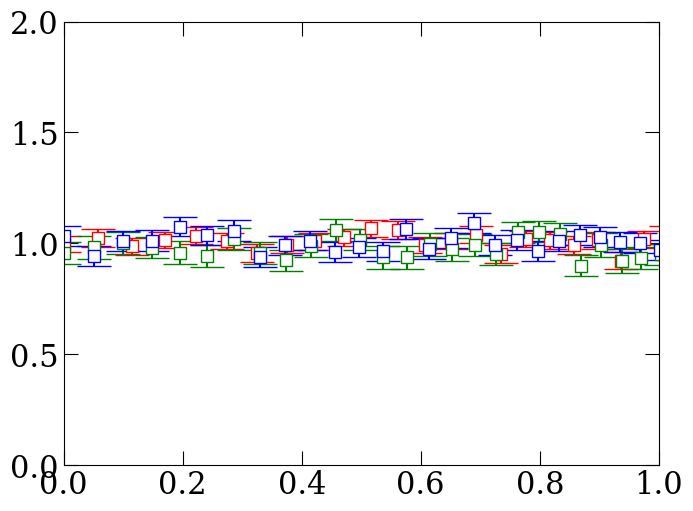

In [2]:
ens2Ncfgs={'b':700,'c':400,'d':500}
ens2n2max={'b':23,'c':26,'d':26}

Q2ss={ens:np.array([getQ2(ens,n2) for n2 in range(ens2n2max[ens]+1)]) for ens in enss}
ffss={ens:np.random.normal(1,1,size=(ens2Ncfgs[ens],ens2n2max[ens]+1)) for ens in enss}

fig, axs=yu.getFigAxs(1,1) 
colorDic={'b':'r','c':'g','d':'b'}
ax=axs[0,0]
ax.set_xlim([0,1])
ax.set_ylim([0,2])
for ens in enss:
    Q2s=Q2ss[ens]
    ffs=ffss[ens]
    ffs_jk=yu.jackknife(ffs)
    mean,err=yu.jackme(ffs_jk)
    
    plt_x=Q2s; plt_y=mean; plt_err=err
    ax.errorbar(plt_x,plt_y,plt_err,color=colorDic[ens],mfc='white',alpha=1)
    
dat=np.concatenate([ffss[ens].reshape(-1) for ens in enss])
print('expected',1,1/np.sqrt(np.sum([ens2Ncfgs[ens]*(ens2n2max[ens]+1) for ens in enss])))
print('jack',yu.jackme(yu.jackknife(dat)))

dat=superjackknife([yu.jackknife(ffss[ens]) for ens in enss])

covs=[yu.jackmec(yu.jackknife(ffss[ens]))[-1] for ens in enss]
dims=[len(cov) for cov in covs]
t=np.block([[covs[i] if i==j else np.zeros([dims[i],dims[j]]) for j in range(len(dims))] for i in range(len(dims))])
def fitfunc(x):
    return np.zeros((dat.shape[-1]))+x
pars_jk,chi2_jk,Ndof=jackfit(fitfunc,dat,[-1],cov=t)
mean,err=yu.jackme(pars_jk)
print('super',mean[0],err[0])
mean,err=yu.jackme(chi2_jk/Ndof)
print('chi2',mean[0],err[0])

print('for 1st')
ens='b'
print('expected',1,1/np.sqrt(ens2Ncfgs[ens]))
mean,err=yu.jackme(yu.jackknife(ffss[ens][:,0]))
print('jack',mean,err)
mean,err=yu.jackme(dat)
print('super',mean[0],err[0])

In [57]:
Q2maxs={'b':99,'c':99,'d':99}
enss=['b','c','d']
with h5py.File('/capstor/store/cscs/userlab/s1174/lyan/code/temp/yan.h5') as f:
    ffss={ens:f[f'data_{str.upper(ens)}'][:,:Q2maxs[ens]] for ens in enss}
    Q2ss={ens:f[f'Q2_{str.upper(ens)}'][:Q2maxs[ens]] for ens in enss}

Nenss={ens:len(ffss[ens]) for ens in enss}; Nens=np.sum([len(ffss[ens]) for ens in enss])
print(Nens,Nenss)

dat=superjackknife([ffss[ens] for ens in enss])
print(dat.shape)

with h5py.File('/capstor/store/cscs/userlab/s1174/lyan/code/temp/superjackknife.h5','w') as f:
    f.create_dataset('dat',data=dat)
meanS,_,covS=yu.jackmec(dat)

print()

mean=np.concatenate([yu.jackme(ffss[ens])[0] for ens in enss])
covs=[yu.jackmec(ffss[ens])[2] for ens in enss]
dims=[len(cov) for cov in covs]; Ntot=np.sum(dims)
cov=np.block([[covs[i] if i==j else np.zeros([dims[i],dims[j]]) for j in range(len(dims))] for i in range(len(dims))])
print('mean',np.max(np.abs(mean)),np.max(np.abs(mean-meanS)))
print('cov',np.max(np.abs(cov)),np.max(np.abs(cov-covS)))

print()

mean=np.concatenate([yu.jackme(ffss[ens])[0] for ens in enss])
covs=[yu.jackmec(ffss[ens])[2] * (Nenss[ens]/(Nenss[ens]-1)) * ((Nens-1)/Nens) for ens in enss]
cov=np.block([[covs[i] if i==j else np.zeros([dims[i],dims[j]]) for j in range(len(dims))] for i in range(len(dims))])
print('mean',np.max(np.abs(mean)),np.max(np.abs(mean-meanS)))
print('cov',np.max(np.abs(cov)),np.max(np.abs(cov-covS)))
print()
print([(Nenss[ens]/(Nenss[ens]-1)) * ((Nens-1)/Nens) for ens in enss])

1629 {'b': 732, 'c': 401, 'd': 496}
(1629, 57)

mean 0.44173703199142833 1.226796442210798e-14
cov 0.0022673473430726374 4.273024151770378e-06

mean 0.44173703199142833 1.226796442210798e-14
cov 0.002271620367224407 8.673617379884035e-19

[1.0007532757417499, 1.0018845917740944, 1.001405088329582]


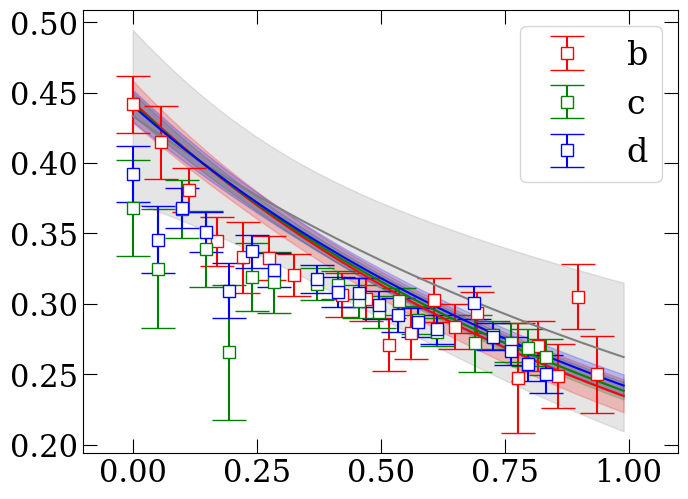

In [42]:
Q2maxs={'b':99,'c':99,'d':99}
enss=['b','c','d']
with h5py.File('/capstor/store/cscs/userlab/s1174/lyan/code/temp/yan.h5') as f:
    ffss={ens:f[f'data_{str.upper(ens)}'][:,:Q2maxs[ens]] for ens in enss}
    Q2ss={ens:f[f'Q2_{str.upper(ens)}'][:Q2maxs[ens]] for ens in enss}

fig, axs=yu.getFigAxs(1,1) 
colorDic={'b':'r','c':'g','d':'b'}
ax=axs[0,0]
ax.set_xlim([-0.1,1.1])
# ax.set_ylim([0,2])
for ens in enss[:]:
    Q2s=Q2ss[ens]
    ffs=ffss[ens]
    ffs_jk=ffs
    mean,err=yu.jackme(ffs_jk)

    plt_x=Q2s; plt_y=mean; plt_err=err
    ax.errorbar(plt_x + 0*{'b':-0.005,'c':0,'d':0.005}[ens],plt_y,plt_err,color=colorDic[ens],mfc='white',alpha=1,label=ens)
ax.legend()

dat=superjackknife([ffss[ens] for ens in enss])
# print(dat.shape)
with h5py.File('/capstor/store/cscs/userlab/s1174/lyan/code/temp/superjackknife.h5','w') as f:
    f.create_dataset('dat',data=dat)
    
covs=[yu.jackmec(ffss[ens])[-1] for ens in enss]
dims=[len(cov) for cov in covs]
t=np.block([[covs[i] if i==j else np.zeros([dims[i],dims[j]]) for j in range(len(dims))] for i in range(len(dims))])
func=lambda Q2,a2,g0,r0,g2,r2:(g0+a2*g2)/((1+Q2*(r0**2+a2*r2**2)/12)**2)
def fitfunc(pars):
    t=np.concatenate([[func(Q2,ens2a[ens],*pars) for Q2 in Q2ss[ens]] for ens in enss])
    return t
pars_jk,chi2_jk,Ndof=jackfit(fitfunc,dat,[0,1,0,1],cov=t)
# pars_jk,chi2_jk,Ndof=jackfit(fitfunc,dat,[0,1,0,1],cov=t,mask='uncorrelated')
mean,err=yu.jackme(pars_jk)

Q2s=np.arange(0,1,0.01)
pars2ffs=lambda pars:[func(Q2,0,*pars) for Q2 in Q2s]
ffs=yu.jackmap(pars2ffs,pars_jk)
mean,err=yu.jackme(ffs)
x=Q2s; ymin=mean-err; ymax=mean+err
ax.plot(x,mean,color='grey',linestyle='solid',marker='')
ax.fill_between(x, ymin, ymax, color='grey', alpha=0.2)
for ens in enss:
    pars2ffs=lambda pars:[func(Q2,ens2a[ens],*pars) for Q2 in Q2s]
    ffs=yu.jackmap(pars2ffs,pars_jk)
    mean,err=yu.jackme(ffs)
    x=Q2s; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=colorDic[ens],linestyle='solid',marker='')
    ax.fill_between(x, ymin, ymax, color=colorDic[ens], alpha=0.2)

[[0.00056026 0.00030129 0.00029353]
 [0.00030129 0.00019227 0.00019018]
 [0.00029353 0.00019018 0.000198  ]]
EigResult(eigenvalues=array([9.02399576e-04, 4.40095895e-05, 4.11986034e-06]), eigenvectors=array([[ 0.77576944,  0.62412975,  0.09297219],
       [ 0.4481238 , -0.44117822, -0.7775261 ],
       [ 0.44425987, -0.64484404,  0.62193998]]))
1


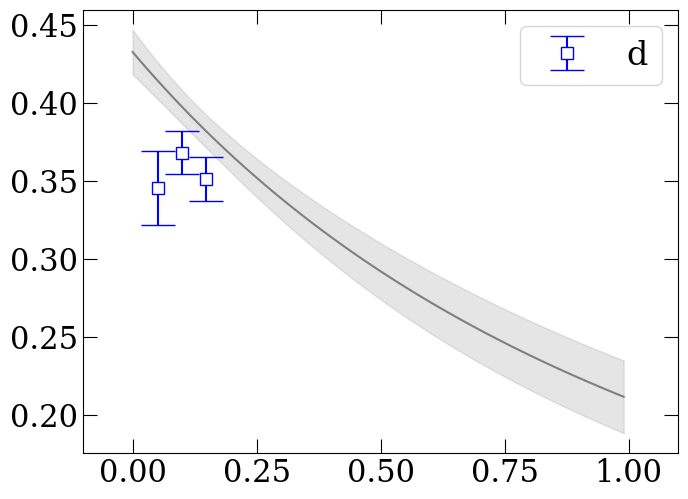

In [43]:
Q2maxs={'b':5,'c':5,'d':4}
# Q2maxs={'b':99,'c':99,'d':99}
# enss=['b','c','d']
enss=['d']
Q2s=[0,2,3,5,6,7,8]
Q2s=[1,2,3]
with h5py.File('/capstor/store/cscs/userlab/s1174/lyan/code/temp/yan.h5') as f:
    ffss={ens:f[f'data_{str.upper(ens)}'][:,Q2s] for ens in enss}
    Q2ss={ens:f[f'Q2_{str.upper(ens)}'][Q2s] for ens in enss}

fig, axs=yu.getFigAxs(1,1) 
colorDic={'b':'r','c':'g','d':'b'}
ax=axs[0,0]
ax.set_xlim([-0.1,1.1])
# ax.set_ylim([0,2])
for ens in enss[:]:
    Q2s=Q2ss[ens]
    ffs=ffss[ens]
    ffs_jk=ffs
    mean,err=yu.jackme(ffs_jk)

    plt_x=Q2s; plt_y=mean; plt_err=err
    ax.errorbar(plt_x + 0*{'b':-0.005,'c':0,'d':0.005}[ens],plt_y,plt_err,color=colorDic[ens],mfc='white',alpha=1,label=ens)
ax.legend()

dat=superjackknife([ffss[ens] for ens in enss])

covs=[yu.jackmec(ffss[ens])[-1] for ens in enss]
t=covs[0]
print(t)
print(np.linalg.eig(t))
dims=[len(cov) for cov in covs]
t=np.block([[covs[i] if i==j else np.zeros([dims[i],dims[j]]) for j in range(len(dims))] for i in range(len(dims))])
func=lambda Q2,a2,g0,r0,g2,r2:(g0+a2*g2)/((1+Q2*(r0**2+a2*r2**2)/12)**2)
def fitfunc(pars):
    t=np.concatenate([[func(Q2,ens2a[ens],*pars,0,0) for Q2 in Q2ss[ens]] for ens in enss])
    return t
pars_jk,chi2_jk,Ndof=jackfit(fitfunc,dat,[0,1],cov=t)
# pars_jk,chi2_jk,Ndof=jackfit(fitfunc,dat,[0,1],cov=t,mask='uncorrelated')
mean,err=yu.jackme(pars_jk)
print(Ndof)

Q2s=np.arange(0,1,0.01)
pars2ffs=lambda pars:[func(Q2,0,*pars,0,0) for Q2 in Q2s]
ffs=yu.jackmap(pars2ffs,pars_jk)
mean,err=yu.jackme(ffs)
x=Q2s; ymin=mean-err; ymax=mean+err
ax.plot(x,mean,color='grey',linestyle='solid',marker='')
ax.fill_between(x, ymin, ymax, color='grey', alpha=0.2)